<a href="https://colab.research.google.com/github/antndlcrx/Oxford-Methods-Spring-School/blob/main/preliminaries/quick_embedding_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://cdn.githubraw.com/antndlcrx/oss_2024/main/images/dpir_oss.png?raw=true:,  width=70" alt="My Image" width=500>

## **Word Embeddings**

Understanding a word's meaning involves more than just its dictionary definition — it includes connotations, context, and how it relates to other words. While humans grasp this intuitively, teaching computers to do the same is a major challenge.

Early models treated words as isolated symbols, ignoring relationships between them. The breakthrough came with **distributional semantics** — the idea that a word's meaning can be inferred from the contexts in which it appears. As the linguist J.R. Firth famously put it: *“You shall know a word by the company it keeps.”*

**Word embeddings** are a powerful way to implement this idea. They represent words as vectors in a multidimensional space, learned from large text corpora. Words that appear in similar contexts end up close to one another in this space, allowing the model to capture nuanced semantic relationships.

> 📚 **Want more?** For an excellent deep dive into Word2Vec, GloVe, and embedding theory, check out [**Lena Voita's NLP for You course**](https://lena-voita.github.io/nlp_course/word_embeddings.html).


In [ ]:
## Intuitive Walkthrough on Embeddings
import numpy as np
import pandas as pd

text = "I like cats very much"
vocab = text.split()
vocab

one_hot = np.eye(len(vocab), dtype=int)
one_hot

one_hot_df = pd.DataFrame(one_hot, index=vocab, columns=vocab)
one_hot_df

,I,like,cats,very,much
I,1,0,0,0,0
like,0,1,0,0,0
cats,0,0,1,0,0
very,0,0,0,1,0
much,0,0,0,0,1


In [ ]:
embeddings = {
    "I":    np.array([0.9, 0.1, 0.2]),
    "like": np.array([0.8, 0.2, 0.4]),
    "cats": np.array([0.2, 0.9, 0.4]),
    "very": np.array([0.1, 0.2, 0.9]),
    "much": np.array([0.2, 0.3, 0.8]),
}
emb_df = pd.DataFrame(embeddings).T
emb_df.columns = ["dim1", "dim2", "dim3"]
emb_df

,dim1,dim2,dim3
I,0.9,0.1,0.2
like,0.8,0.2,0.4
cats,0.2,0.9,0.4
very,0.1,0.2,0.9
much,0.2,0.3,0.8


**Cosine similarity** is a measure of similarity between two vectors based on the **cosine of the angle** between them. It is widely used in word embeddings to determine how similar two words are in a high-dimensional space.

Given two vectors **A** and **B**, the cosine similarity is computed as:

$$ \text{cosine similarity}(A, B) = \frac{A \cdot B}{\|A\| \|B\|} $$

Where:
- \$( A \cdot B \)$ is the **dot product** of the two vectors.
- \( \|A\| \) and \( \|B\| \) are the **Euclidean norms (magnitudes)** of the vectors.

**Interpretation**
- **Cosine similarity = 1** → The vectors are **identical** (point in the same direction).
- **Cosine similarity = 0** → The vectors are **orthogonal** (unrelated).
- **Cosine similarity = -1** → The vectors are **opposites** (point in opposite directions).

In [ ]:
from numpy.linalg import norm

def cosine_sim(a, b):
    """
    dot product over the product of vector magnitudes.
    Shows if vectors point in same or opposite directions or are orthogonal.
    """
    # result = np.sum(a * b) / (np.sqrt(np.sum(a**2)) * np.sqrt(np.sum(b**2)))
    result = np.dot(a, b) / (norm(a) * norm(b))
    return result

cosine_sim(one_hot_df["very"], one_hot_df["much"])  # 0.0
cosine_sim(one_hot_df["I"], one_hot_df["cats"])     # 0.0

# cosine_sim(embeddings["very"], embeddings["much"])  # ~0.98
# cosine_sim(embeddings["I"], embeddings["cats"])     # ~0.37

np.float64(0.0)

### Pretrained Embeddings

In [ ]:
# runs about 2mins, you might need to restart session
!pip install --upgrade gensim

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import gensim.downloader as api

import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
top_words = model.index_to_key[:500]
embeddings = np.asarray([model.get_vector(word) for word in top_words])

In [ ]:
#@title Build an Intuition on Word Embeddings

tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings_2d = tsne.fit_transform(embeddings)

fig = go.Figure(data=[go.Scatter(
    x=reduced_embeddings_2d[:, 0],  # t-SNE dimension 1
    y=reduced_embeddings_2d[:, 1],  # t-SNE dimension 2
    mode='markers+text',
    text=top_words,
    textposition="bottom center"
)])

fig.update_layout(
    title='2D t-SNE Visualization of the Top 1000 Most Frequent Words',
    xaxis_title='t-SNE Dimension 1',
    yaxis_title='t-SNE Dimension 2'
)

fig.show()

In [ ]:
#@title Helper Function for Vector Arithmetic

def find_analogy(positive, negative, topn=1):
    """
    Computes a word analogy of the form:
        base - remove + add = ?

    Example:
        find_analogy(positive=['king', 'woman'], negative=['man'])

    This calculates:
        king - man + woman = ?

    Parameters:
        positive (list): Words to add in the vector arithmetic (e.g., ['king', 'woman']).
        negative (list): Words to subtract (e.g., ['man']).
        topn (int): Number of closest words to return.

    Returns:
        None (prints the results)
    """
    if not positive or not negative:
        raise ValueError("Both 'positive' and 'negative' lists must contain at least one word.")

    # Check if words exist in the model's vocabulary
    for word in positive + negative:
        if word not in model.key_to_index:
            print(f"Warning: '{word}' is not in the model vocabulary. Skipping analogy.")
            return

    # Compute analogy
    results = model.most_similar(positive=positive, negative=negative, topn=topn)

    # Format the equation output to reflect the intended order
    equation = f"{positive[0]} - {negative[0]} + {positive[1]} = ?"


    print(f"Analogy: {equation}\n")
    for rank, (word, similarity) in enumerate(results, start=1):
        print(f"{rank}. {word} (similarity score: {similarity:.2f})")

# Example usage:
# find_analogy(positive=['king', 'woman'], negative=['man'], topn=3)


In [ ]:
# Example use
positive_words = ['king', 'woman']
negative_words = ['man']
find_analogy(positive_words, negative_words, topn=3)

Analogy: king - man + woman = ?

1. queen (similarity score: 0.77)
2. monarch (similarity score: 0.68)
3. throne (similarity score: 0.68)


In [ ]:
# paris - france + germany
pos = ['paris', 'germany']
neg = ['france']

find_analogy(pos, neg, topn=3)

Analogy: paris - france + germany = ?

1. berlin (similarity score: 0.88)
2. frankfurt (similarity score: 0.80)
3. vienna (similarity score: 0.77)


In [ ]:
# doctor - man + woman
pos = ['doctor', 'woman']
neg = ['man']

find_analogy(pos, neg, topn=3)

Analogy: doctor - man + woman = ?

1. nurse (similarity score: 0.77)
2. physician (similarity score: 0.72)
3. doctors (similarity score: 0.68)


In [ ]:
#@title Try yourself!

pos = []
neg = []

find_analogy(pos, neg)

### **Semantic Projection**


[**Semantic projection**](https://www.nature.com/articles/s41562-022-01316-8) is a method (introduced by Grand et al. 2022) for extracting context-dependent relationships from word embeddings by mapping words onto interpretable semantic scales. As such, semantic projection allows us to analyze words along specific conceptual dimensions.

**How It Works**

To define a semantic scale for a particular feature (e.g., size, danger), we use a **vector difference** between two antonyms that represent opposite ends of the feature spectrum. For example, to construct a **size scale**, we compute:

$$ \vec{\text{size}} = \vec{\text{large}} - \vec{\text{small}} $$

Once this vector is obtained, we **project** word embeddings (e.g., different animals) onto this scale using the **dot product**, which measures how much a word vector aligns with the semantic dimension:

$$ \text{projection}(\vec{w}) = \vec{w} \cdot \vec{\text{size}} $$

This process allows us to **rank words** according to their position on the scale. For example, projecting "horse" onto the **size vector** will place it between "rabbit" and "elephant," reflecting common knowledge about animal sizes. The same approach can be applied to **other properties**, such as **dangerousness**, by defining a "safe-dangerous" axis.

**Why do we care?**
Semantic projection enables us to model human-like judgments about word relationships in a way that standard word embeddings do not. It reveals hidden structure in word embeddings, uncovering conceptual dimensions that influence how we understand relationships between words in different contexts. This method provides a simple yet powerful tool for analyzing word meaning in a flexible and interpretable way.

In [ ]:
# define dimensions

gender_pairs = [
    ("boy", "girl"),
    ("man", "woman"),
    ("father", "mother"),
    ("husband", "wife")
]

age_pairs = [
    ("baby", "elder"),
    ("child", "grandparent"),
    ("young", "aged"),
    ("newborn", "senior"),
    ("infant", "elderly")
]

In [ ]:
#@title Helper functions for Semantic Projection

def calculate_unit_vector(pairs):
    vectors = [model[word1] - model[word2] for word1, word2 in pairs]
    unit_vector = np.mean(vectors, axis=0)
    unit_vector /= np.linalg.norm(unit_vector)
    return unit_vector

def calculate_residual_unit_vector(pairs, x_unit_vector, y_unit_vector):
    vectors = [model[word1] - model[word2] for word1, word2 in pairs]
    residual_vectors = [vector - (vector @ x_unit_vector) * x_unit_vector - (vector @ y_unit_vector) * y_unit_vector for vector in vectors]
    residual_unit_vector = np.mean(residual_vectors, axis=0)
    residual_unit_vector /= np.linalg.norm(residual_unit_vector)
    return residual_unit_vector

def calculate_3d_coordinates(words, x_unit_vector, y_unit_vector, residual_unit_vector):
    x_coords = [model[word] @ x_unit_vector for word in words]
    y_coords = [model[word] @ y_unit_vector for word in words]
    z_coords = [2 * (1 - model[word] @ residual_unit_vector) * 0.1 for word in words]
    return x_coords, y_coords, z_coords


def visualize_words_in_3d(words, x_pairs, y_pairs, title_x, title_y, model):
    """
    This function creates a 3D scatter plot visualizing the words based on x, y, and a residual dimension.

    Args:
        words: A list of words (assumed to have "_NOUN" prefix).
        x_pairs: list of tuples representing the x axis.
        y_pairs: list of tuples representing the y axis.

    Returns:
        None (displays the plot directly).
    """
    x_unit_vector = calculate_unit_vector(x_pairs)
    y_unit_vector = calculate_unit_vector(y_pairs)
    residual_unit_vector = calculate_residual_unit_vector(x_pairs + y_pairs, x_unit_vector, y_unit_vector)

    x_coords, y_coords, z_coords = calculate_3d_coordinates(words, x_unit_vector, y_unit_vector, residual_unit_vector)

    def normalize_to_range(coords):
        min_val = np.min(coords)
        max_val = np.max(coords)
        return 2 * (coords - min_val) / (max_val - min_val) - 1

    x_coords = normalize_to_range(x_coords)
    y_coords = normalize_to_range(y_coords)
    z_coords = normalize_to_range(z_coords)

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_coords, y_coords, z_coords, c='blue', s=50)

    for word, x, y, z in zip(words, x_coords, y_coords, z_coords):
        ax.text(x, y, z, word.split('_')[0], fontsize=10, color='black')

    ax.set_xlabel(title_x)
    ax.set_ylabel(title_y)
    ax.set_zlabel('Residual Dimension')

    ax.set_title(f'3D Semantic Projection: {title_x} vs {title_y}')
    plt.show()

### interactive version ###
# def visualize_words_in_3d(words, x_pairs, y_pairs, title_x, title_y):
#   """
#   This function creates a 3D scatter plot visualizing the words based on x, y, and a residual dimension.

#   Args:
#       words: A list of words (assumed to have "_NOUN" prefix).
#       x_pairs: list of tuples representing the x axis.
#       y_pairs: list of tuples representing the y axis.

#   Returns:
#       None (displays the plot directly).
#   """

#   x_unit_vector = calculate_unit_vector(x_pairs)
#   y_unit_vector = calculate_unit_vector(y_pairs)
#   residual_unit_vector = calculate_residual_unit_vector(x_pairs + y_pairs, x_unit_vector, y_unit_vector)
#   x_coords, y_coords, z_coords = calculate_3d_coordinates(words, x_unit_vector, y_unit_vector, residual_unit_vector)

#   fig = go.Figure()
#   fig.add_trace(go.Scatter3d(
#       x=x_coords,
#       y=y_coords,
#       z=z_coords,
#       mode='markers+text',
#       text=[word.split('_')[0] for word in words],  # Remove prefix and display word labels
#       hoverinfo='text',  # Display word labels on hover
#       marker=dict(size=12, color='blue')
#   ))

#   fig.update_layout(
#       scene=dict(
#           xaxis_title=f'{title_x}',
#           yaxis_title=f'{title_y}',
#           zaxis_title='Residual Dimension'
#       ),
#       width=700,
#       margin=dict(r=20, b=10, l=10, t=10)
#   )
#   fig.show()

In [ ]:
gender_words = [
    "boy", "girl", "man", "woman",
    "father", "mother", "brother", "sister",
    "husband", "wife", "gentleman", "lady",
    "king", "queen", "actor", "actress",
    "hero", "heroine", "uncle", "aunt",
    "groom", "bride", "prince", "princess"
]

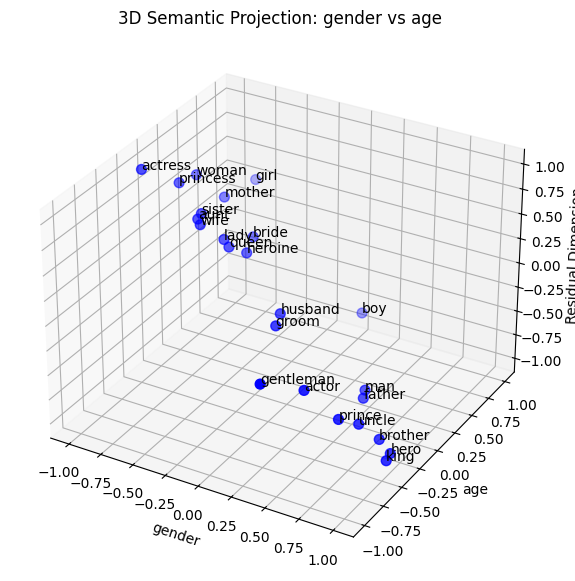

In [ ]:
visualize_words_in_3d(gender_words, gender_pairs, age_pairs, 'gender', 'age', model=model)

In [ ]:
#@title Exercise Semantic Projection

# 1: Think of a research problem where semantic projection could be a useful data
# analysis tool. Which dimensions would be necessary to highlight? How would you define them?
# Which individual concepts (words) would be interesting to project?

# 2: Implement the dimension definitions, create a list of concepts, and visualise your projections!
